# Super Fibonacci spirals

Created 23/05/2024

Objectives:

* Implement super Fibonacci spirals to get sample of $SU(2)$ unitaries.
* Get convex hull of resulting points using scipy, and use to calculate dispersion.
* Investigate scaling between dispersion and number of points.
* Map point on $SO(3)$ back to $SU(2)$.

Based on this paper: https://openaccess.thecvf.com/content/CVPR2022/papers/Alexa_Super-Fibonacci_Spirals_Fast_Low-Discrepancy_Sampling_of_SO3_CVPR_2022_paper.pdf

# Package imports and constants

In [31]:
import numpy as np
import math
import matplotlib.pyplot as plt

from scipy.spatial import ConvexHull

In [2]:
C1 = math.sqrt(2)
C2 = 1.533751168755204288118041

# Code
## Superfibonacci spirals

In [6]:
a = np.zeros((10,4))

In [11]:
def super_fibonacci_point(n, s, phi=C1, psi=C2):
    t = s/n
    d = 2*math.pi*s
    r = math.sqrt(t)
    R = math.sqrt(1-t)
    alpha = d/phi
    beta = d/psi
    point = [
        r*math.sin(alpha),
        r*math.cos(alpha),
        R*math.sin(beta),
        R*math.cos(beta)
    ]

    return point

In [15]:
def super_fibonacci(n, phi=C1, psi=C2):
    out = np.zeros((n,4))

    for i in range(n):
        s = i + 0.5
        point = super_fibonacci_point(n, s, phi=C1, psi=C2)
        out[i] = point

    return out

In [61]:
a = super_fibonacci(1000)

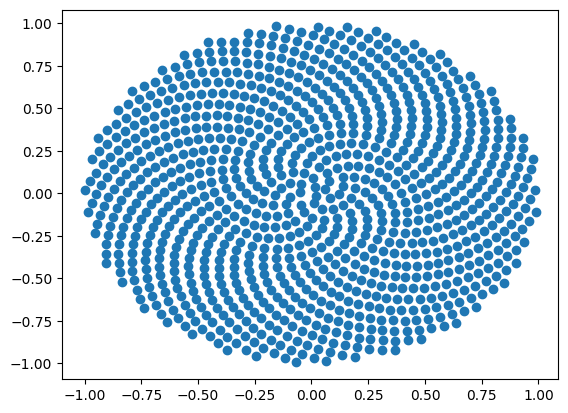

In [22]:
plt.scatter(a[:,0], a[:,1])

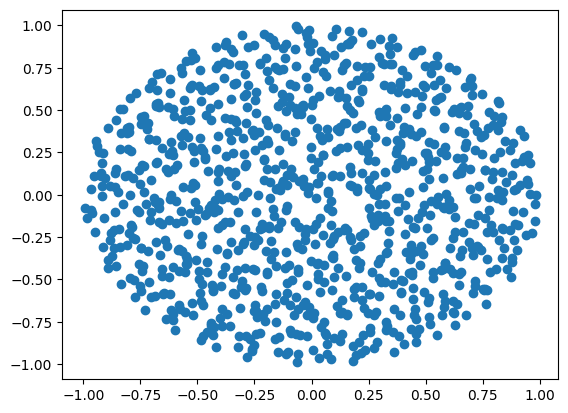

In [23]:
plt.scatter(a[:,1], a[:,2])

In [29]:
norms = np.linalg.norm(a, axis=1)

In [30]:
np.min(norms), np.max(norms)

(0.9999999999999998, 1.0000000000000002)

## Circumradius of 4 points in D spatial dimensions
Relevant formula derived here: https://en.wikipedia.org/wiki/Tetrahedron

In [44]:
def get_circumradius(x1, x2, x3, x4):
    a = np.linalg.norm(x1-x2)
    b = np.linalg.norm(x1-x3)
    c = np.linalg.norm(x1-x4)

    A = np.linalg.norm(x3-x4)
    B = np.linalg.norm(x2-x4)
    C = np.linalg.norm(x2-x3)

    X = b**2 + c**2 - A**2
    Y = a**2 + c**2 - B**2
    Z = b**2 + a**2 - C**2

    V = math.sqrt(4*((a*b*c)**2) - (a*X)**2 - (b*Y)**2 - (c*Z)**2 + X*Y*Z)/12

    
    r_numerator = math.sqrt(
        (a*A + b*B + c*C)*
        (a*A + b*B - c*C)*
        (a*A - b*B + c*C)*
        (-a*A + b*B + c*C)
    )

    r = r_numerator/(24*V)

    return r

In [52]:
x1 = np.array([1,0,-1/math.sqrt(2)])
x2 = np.array([-1,0,-1/math.sqrt(2)])
x3 = np.array([0,1,1/math.sqrt(2)])
x4 = np.array([0,-1,1/math.sqrt(2)])

In [53]:
get_circumradius(x1, x2, x3, x4)

1.224744871391589

In [54]:
math.sqrt(3/2)

1.224744871391589

## Convex hull/delauney triangulation

In [32]:
hull = ConvexHull(a)

In [33]:
hull

In [34]:
hull.simplices

array([[480, 497, 316, 408],
       [975, 900, 958, 999],
       [589, 480, 497, 408],
       ...,
       [617, 709, 890, 634],
       [617, 815, 890, 798],
       [617, 709, 890, 798]], dtype=int32)

In [69]:
def get_dispersion(points, convex_hull):
    dispersion = max(
        get_circumradius(*points[simplex])
        for simplex in convex_hull.simplices
    )
    return dispersion

In [66]:
disps = [get_circumradius(*a[simplex]) for simplex in hull.simplices]

In [67]:
(min(disps), max(disps))

(0.15624286883334598, 0.27733286457973966)

In [68]:
np.std(np.array(disps))

0.016167523856112146

In [65]:
get_dispersion(a, hull)

0.15624286883334598

In [71]:
dispersions = dict()

In [74]:
for i in range(10, 10000, 30):
    if i not in dispersions:
        X = super_fibonacci(i)
        hull = ConvexHull(X)
        disp = get_dispersion(X, hull)
        dispersions[i] = disp

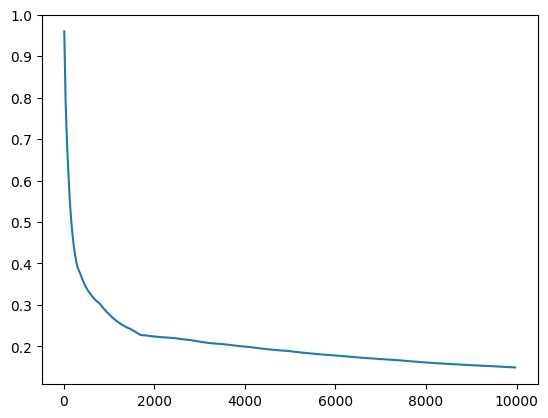

In [76]:
plt.plot(dispersions.keys(), dispersions.values())

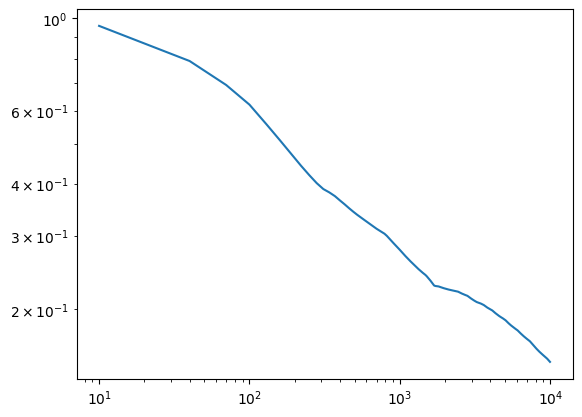

In [78]:
plt.loglog(dispersions.keys(), dispersions.values())

In [98]:
min(dispersions.values())

0.14907238863647196

In [81]:
from sklearn.linear_model import LinearRegression

In [92]:
X = np.expand_dims(np.log(list(dispersions.keys())),1)
Y = np.log(list(dispersions.values()))

In [93]:
reg = LinearRegression().fit(X, Y)

In [96]:
reg.score(X, Y)

0.9886460863267803

In [97]:
reg.coef_

array([-0.2727698])

# Conclusion

Painfully slow convergence. $d \sim N^{-1/4}$ so to halve $d$ would require upscaling $N$ by 16. So to get $d=0.075$ would require $160,000$ points, and $d=0.04$ would require $2.5$ million points.